# Check deep ocean Temperature in spinup and run files

spinup1,2,3 are files covering 1950-1960. Spinup1 starts from the ORA-20C lateral forcing initial file 'clim'. Spinup2 starts using the last date of spinup1 as initial file, spinup3 uses spinup2 and run3 uses spinup3.


In this notebook it is checked whether the spinup works well by comparing deep ocean temperatures. To do so, the temperatures below 2000m are averaged and summed over depth and these values are compared.

In [56]:
import xarray as xr
import numpy as np
import xesmf as xe

import matplotlib.pyplot as plt

In [2]:
spinup1 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/spinup1/NorthSea4_avg.nc')
spinup2 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/spinup2/NorthSea4_avg.nc')
spinup3 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/spinup3/NorthSea4_avg.nc')
run3 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/run3/NorthSea4_avg_annual.nc')
ora20c = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ORA20C/forcing input/ora20c.nc')
clim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/lateral forcing/NorthSea4 ORA20C/NorthSea4_clim_ORA20C_1950116_to_20091216.nc')

## Create latitude, longitude files of ROMS output

In [14]:
# Create new dataset of sea level, temperature and salinity with dimensions s_rho, lat and lon

# Run3
data_vars = dict(temp=(["time", "s_rho", "latitude", "longitude"], run3.temp.values),)

coords = dict(time=(["time"], run3.ocean_time.values),
              s_rho=(["s_rho"], run3.s_rho.values),
             latitude=(["latitude"], run3.lat_rho.values[:,0]),
             longitude=(["longitude"], run3.lon_rho.values[0]))



run3_rg = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )


# Spinup1
data_vars = dict(temp=(["time", "s_rho", "latitude", "longitude"], spinup1.temp.values),)

coords = dict(time=(["time"], spinup1.ocean_time.values),
              s_rho=(["s_rho"], spinup1.s_rho.values),
             latitude=(["latitude"], spinup1.lat_rho.values[:,0]),
             longitude=(["longitude"], spinup1.lon_rho.values[0]))



spinup1_rg = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )


# Spinup2
data_vars = dict(temp=(["time", "s_rho", "latitude", "longitude"], spinup1.temp.values),)

coords = dict(time=(["time"], spinup1.ocean_time.values),
              s_rho=(["s_rho"], spinup1.s_rho.values),
             latitude=(["latitude"], spinup1.lat_rho.values[:,0]),
             longitude=(["longitude"], spinup1.lon_rho.values[0]))



spinup1_rg = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )


# Spinup3
data_vars = dict(temp=(["time", "s_rho", "latitude", "longitude"], spinup3.temp.values),)

coords = dict(time=(["time"], spinup3.ocean_time.values),
              s_rho=(["s_rho"], spinup3.s_rho.values),
             latitude=(["latitude"], spinup3.lat_rho.values[:,0]),
             longitude=(["longitude"], spinup3.lon_rho.values[0]))



spinup3_rg = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )


# Clim
data_vars = dict(temp=(["time", "s_rho", "latitude", "longitude"], clim.temp.values),)

coords = dict(time=(["time"], clim.ocean_time.values),
              s_rho=(["s_rho"], clim.s_rho.values),
             latitude=(["latitude"], clim.lat_rho.values[:,0]),
             longitude=(["longitude"], clim.lon_rho.values[0]))



clim_rg = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )




## Regrid ORA reanalysis to ROMS grid and obtain deep ocean temperature average and sum

In [51]:
# Obtain deep ocean Temperature average and sum for reanalysis data


# Select data below 2000m
ora20c_deep = ora20c.where(ora20c.depth > 2000, drop = True)


# Select data from 1950
ora20c_deep = ora20c_deep.where(ora20c_deep.time.dt.year > 1949, drop = True)


# Sort coordinates in increasing order
ora20c_deep = ora20c_deep.sortby(['latitude', 'longitude'])


# Select ROMS domain
ora20c_deep = ora20c_deep.where((ora20c_deep.longitude > -20) & (ora20c_deep.longitude < 10) & (ora20c_deep.latitude > 36) & (ora20c_deep.latitude < 62), drop = True)


# Transpose dimensions
ora20c_deep = ora20c_deep.transpose('depth', 'time', 'latitude', 'longitude')


# Obtain sum and average
ora20c_deepT_avg = ora20c_deep.mean('depth')
ora20c_deepT_sum = ora20c_deep.sum('depth')


# Obtain average for regrid
input_grid = run3_rg.mean('s_rho')



# Make arrays C_CONTIGUOUS
input_grid = input_grid.astype(dtype = 'float32', order = 'C')
ora20c_deepT_avg = ora20c_deepT_avg.astype(dtype = 'float32', order = 'C')
ora20c_deepT_sum = ora20c_deepT_sum.astype(dtype = 'float32', order = 'C')


# Add mask
ora20c_deepT_avg['mask'] = xr.where(~np.isnan(ora20c_deepT_avg.thetao.isel(time=0)), 1, 0)
ora20c_deepT_sum['mask'] = xr.where(~np.isnan(ora20c_deepT_sum.thetao.isel(time=0)), 1, 0)
input_grid['mask'] = xr.where(~np.isnan(input_grid.temp.isel(time=0)), 1, 0)


# Build regridder
regridder_ora_avg = xe.Regridder(ora20c_deepT_avg, input_grid, "bilinear", extrap_method= 'nearest_s2d')
regridder_ora_sum = xe.Regridder(ora20c_deepT_sum, input_grid, "bilinear", extrap_method= 'nearest_s2d')



# Apply to data
ora20c_deepT_avg = regridder_ora_avg(ora20c_deepT_avg).thetao
ora20c_deepT_sum = regridder_ora_avg(ora20c_deepT_sum).thetao


# Obtain annual averages
ora20c_deepT_avg_y = ora20c_deepT_avg.groupby(ora20c_deepT_avg.time.dt.year).mean('time')
ora20c_deepT_sum_y = ora20c_deepT_sum.groupby(ora20c_deepT_sum.time.dt.year).mean('time')




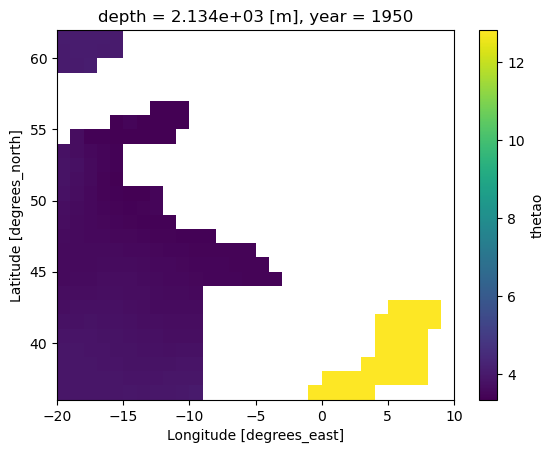

In [81]:
ora20c_deep.isel(depth=0).groupby(ora20c_deep.time.dt.year).mean('time').isel(year=0).thetao.plot()

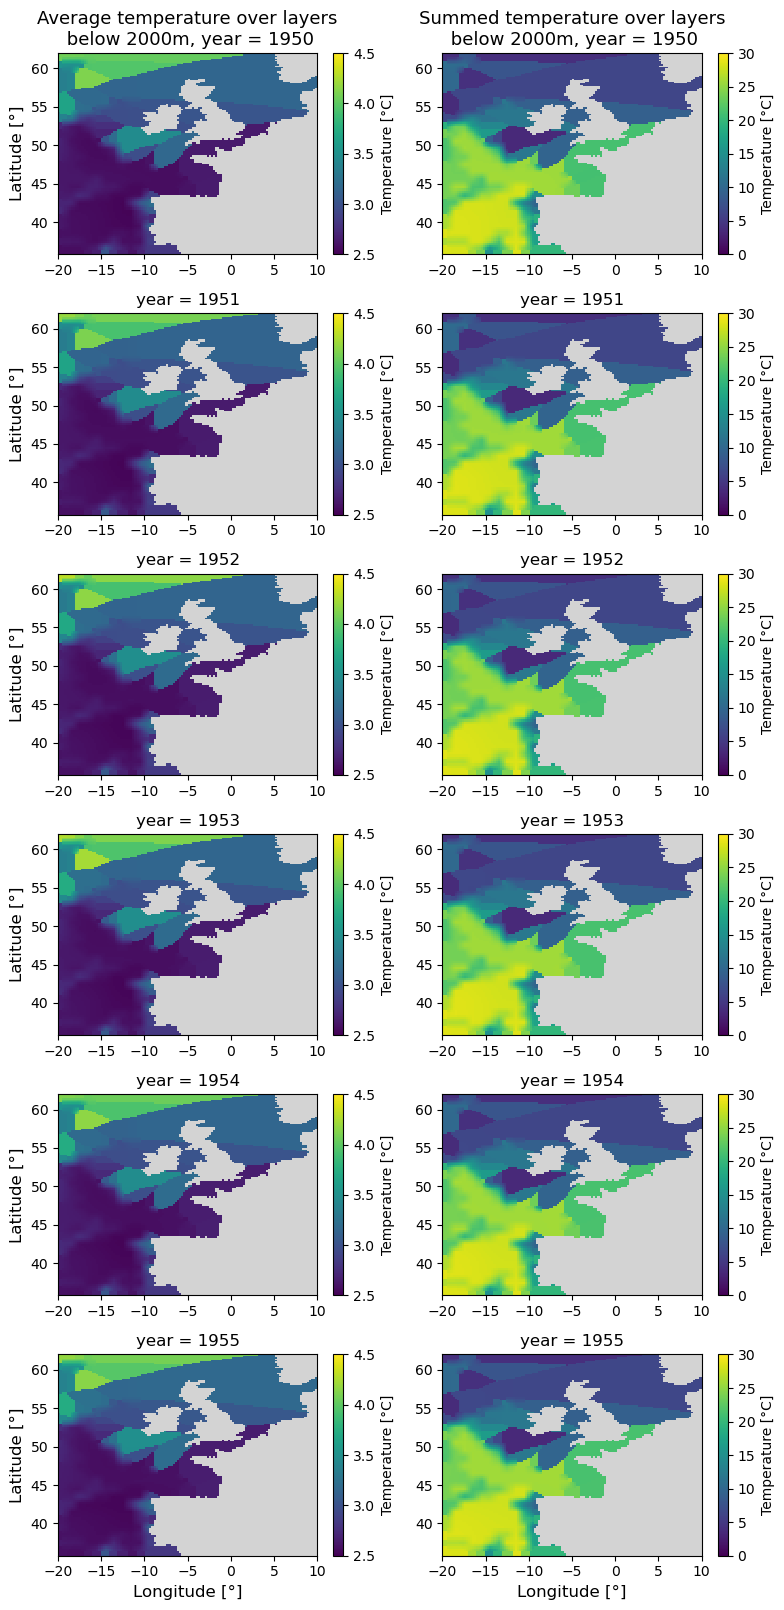

In [76]:
# Create plots of maps over time
years = range(1950, 2010, 10)



# Create figures
nrows = len(years)
fig, axes = plt.subplots(ncols = 2, nrows = nrows, figsize = (8, 2.7*nrows))

for i in range(nrows):
    
    
    # Change facecolor
    axes[i,0].set_facecolor('lightgray')
    axes[i,1].set_facecolor('lightgray')
    
    
    # Plot maps
    ora20c_deepT_avg_y.isel(year = i).plot(ax = axes[i, 0], vmin = 2.5, vmax = 4.5, cbar_kwargs={"label": "Temperature [°C]"})
    
    ora20c_deepT_sum_y.isel(year = i).plot(ax = axes[i, 1], vmin = 0, vmax = 30, cbar_kwargs={"label": "Temperature [°C]"})
    
    
    
    # Set axes and titles
    axes[i, 0].set_ylabel('Latitude [°]', fontsize = 12)
    axes[i, 1].set_ylabel('')
    axes[i, 0].set_xlabel('')
    axes[i, 1].set_xlabel('')
    
axes[nrows-1, 0].set_xlabel('Longitude [°]', fontsize = 12)
axes[nrows-1, 1].set_xlabel('Longitude [°]', fontsize = 12)

axes[0,0].set_title('Average temperature over layers\n below 2000m, year = 1950', fontsize = 13)
axes[0,1].set_title('Summed temperature over layers\n below 2000m, year = 1950', fontsize = 13)


plt.tight_layout()

## Obtain averaged and summed temperature below 2000m

In [82]:
run3_rg

<xarray.Dataset>
Dimensions:    (time: 59, s_rho: 30, latitude: 110, longitude: 122)
Coordinates:
  * time       (time) datetime64[ns] 1950-12-31 1951-12-31 ... 2008-12-31
  * s_rho      (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.08333 -0.05 -0.01667
  * latitude   (latitude) float64 35.95 36.25 36.56 36.86 ... 61.56 61.74 61.91
  * longitude  (longitude) float64 -19.88 -19.63 -19.39 ... 9.385 9.631 9.877
Data variables:
    temp       (time, s_rho, latitude, longitude) float32 2.088 2.087 ... nan

In [83]:
run3

<xarray.Dataset>
Dimensions:        (ocean_time: 59, tracer: 2, boundary: 4, s_rho: 30, s_w: 31,
                    eta_rho: 110, xi_rho: 122, eta_u: 110, xi_u: 121,
                    eta_v: 109, xi_v: 122, eta_psi: 109, xi_psi: 121)
Coordinates:
  * ocean_time     (ocean_time) datetime64[ns] 1950-12-31 ... 2008-12-31
  * s_rho          (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w            (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho        (eta_rho, xi_rho) float64 -19.88 -19.63 ... 9.631 9.877
    lat_rho        (eta_rho, xi_rho) float64 35.95 35.95 35.95 ... 61.91 61.91
    lon_u          (eta_u, xi_u) float64 -19.75 -19.51 -19.26 ... 9.508 9.754
    lat_u          (eta_u, xi_u) float64 35.95 35.95 35.95 ... 61.91 61.91 61.91
    lon_v          (eta_v, xi_v) float64 -19.88 -19.63 -19.39 ... 9.631 9.877
    lat_v          (eta_v, xi_v) float64 36.1 36.1 36.1 ... 61.82 61.82 61.82
    lon_psi        (eta_psi, xi_psi) float64 -19.75 -19.51 ... 9.508 9.754
    lat_psi        (eta_psi, xi_psi) float64 36.1 36.1 36.1 ... 61.82 61.82
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/77)
    ntimes         (ocean_time) float64 1.261e+07 1.261e+07 ... 1.261e+07
    ndtfast        (ocean_time) float64 30.0 30.0 30.0 30.0 ... 30.0 30.0 30.0
    dt             (ocean_time) float64 150.0 150.0 150.0 ... 150.0 150.0 150.0
    dtfast         (ocean_time) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    dstart         (ocean_time) datetime64[ns] 1950-01-15 ... 1950-01-15
    nHIS           (ocean_time) float64 2.88e+03 2.88e+03 ... 2.88e+03 2.88e+03
    ...             ...
    vbar           (ocean_time, eta_v, xi_v) float32 ...
    temp           (ocean_time, s_rho, eta_rho, xi_rho) float32 2.088 ... nan
    salt           (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    rho            (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    Huon           (ocean_time, s_rho, eta_u, xi_u) float32 ...
    Hvom           (ocean_time, s_rho, eta_v, xi_v) float32 ...

In [89]:
run3.theta_b

<xarray.DataArray 'theta_b' (ocean_time: 59)>
array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.])
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 1950-12-31 1951-12-31 ... 2008-12-31

In [87]:
# Obtain depth for run3
h = run3.h
hc = run3.hc
theta = run3.theta

AttributeError: 'Dataset' object has no attribute 'theta'

In [86]:
h

<xarray.DataArray 'h' (ocean_time: 59, eta_rho: 110, xi_rho: 122)>
[791780 values with dtype=float64]
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 1950-12-31 1951-12-31 ... 2008-12-31
    lon_rho     (eta_rho, xi_rho) float64 -19.88 -19.63 -19.39 ... 9.631 9.877
    lat_rho     (eta_rho, xi_rho) float64 35.95 35.95 35.95 ... 61.91 61.91
Dimensions without coordinates: eta_rho, xi_rho